**<center><h1>Car Description Generation</h1></center>**

In this part our project, we are going to generate a car's description based on it's brand, model and year. But first we are going to explore the dataset that we are going to use, then we are going to summarize the description of each variable in order to have a summary of the most relevant informations in the dataset.

### **Table of Contents**

1. Import & Install Libraries
2. EDA
3. Data Preparation
4. Text Summarization
5. Text Generation

### **1. Import & Install Libraries**

In [ ]:
!pip install bert-extractive-summarizer
!pip install transformers
!pip install spacy
!pip install tqdm

In [ ]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math

from summarizer import Summarizer,TransformerSummarizer
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import logging

import warnings
warnings.filterwarnings('ignore')

### **2. EDA**

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-description-dataset/carsSemiProcessed.csv


In [ ]:
df_cars = pd.read_csv("/kaggle/input/car-description-dataset/carsSemiProcessed.csv")

In [ ]:
df_cars.head()

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions
0,jeep,jeep wrangler,1998.0,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",Jeep has improved off-road capability by incre...,4.3 out of 5 stars,"$2,423","$4,074",N/A \n,"Inline 4 cylinder \n Horsepower: 120 hp @ 5,40...",Type: four wheel drive \n Transmission: 5-spee...,Length: 147.7 in. / Height: 69.6 in. \n Overal...
1,lexus,lexus is-350,2014.0,https://www.edmunds.com/lexus/is-350/2014/review/,"['Powerful and refined V6', 'superbly crafted ...","[""Handling isn't very sharp, even with the F S...","For 2014, the Lexus IS 350 is redesigned. High...",4.6 out of 5 stars,"$23,990","$27,990","$39,615 \n","V6 cylinder \n Horsepower: 306 hp @ 6,400 rpm ...",Type: rear wheel drive \n Transmission: 8-spee...,Length: 183.7 in. / Height: 56.3 in. \n Overal...
2,toyota,toyota 4runner,2005.0,https://www.edmunds.com/toyota/4runner/2005/re...,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...",The base V6 now comes with a five-speed automa...,4.8 out of 5 stars,"$4,364","$6,983","$27,795 \n","V6 cylinder \n Horsepower: 245 hp @ 5,200 rpm ...",Type: rear wheel drive \n Transmission: 5-spee...,Length: 189.0 in. / Height: 68.5 in. \n Overal...
3,toyota,toyota tundra,2002.0,https://www.edmunds.com/toyota/tundra/2002/rev...,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,"SR5 models have new 16-inch wheels, and a limi...",4.7 out of 5 stars,"$3,324","$5,612","$15,605 \n","V6 cylinder \n Horsepower: 190 hp @ 4,800 rpm ...",Type: rear wheel drive \n Transmission: 5-spee...,Length: 217.5 in. / Height: 70.5 in. \n Bed Le...
4,acura,acura rdx,2017.0,https://www.edmunds.com/acura/rdx/2017/review/,['Strong acceleration and fuel economy from st...,['Technology interface can be distracting to u...,The Acura RDX essentially carries over unchang...,4.3 out of 5 stars,"$19,982","$29,990","$35,670 \n","V6 cylinder \n Horsepower: 279 hp @ 6,200 rpm ...",Type: front wheel drive \n Transmission: 6-spe...,Length: 184.4 in. / Height: 65.0 in. \n Overal...


In [ ]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   car type           3486 non-null   object 
 1   car name           3486 non-null   object 
 2   year               3473 non-null   float64
 3   url                3486 non-null   object 
 4   Pros               3486 non-null   object 
 5   Cons               3486 non-null   object 
 6   Full Description   3486 non-null   object 
 7   rating             3054 non-null   object 
 8   current price Min  3075 non-null   object 
 9   current price Max  3075 non-null   object 
 10  base msrp          3433 non-null   object 
 11  engine             3429 non-null   object 
 12  drivetrain         3479 non-null   object 
 13  dimensions         3471 non-null   object 
dtypes: float64(1), object(13)
memory usage: 381.4+ KB


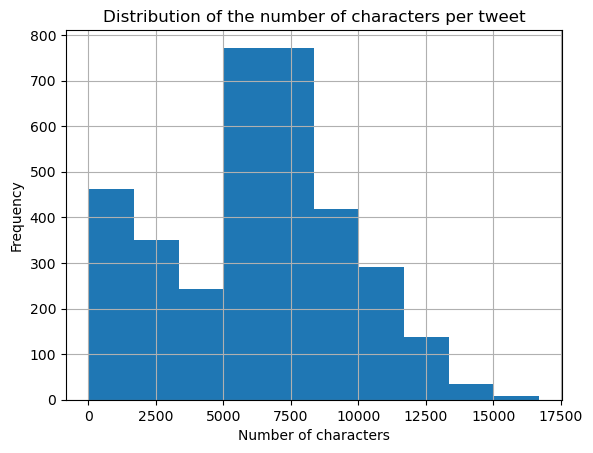

In [ ]:
# Create a histogram of the distribution of the number of characters in each tweet
df_cars["Full Description"].str.len().hist()

# Add labels and a title to the plot
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.title('Distribution of the number of characters per tweet')

# Display the plot
plt.show()

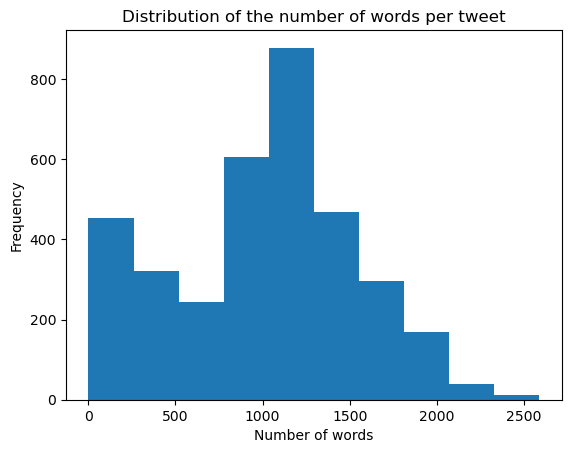

In [ ]:
df_cars["num_words"] = df_cars["Full Description"].apply(lambda x: len(x.split()))

# Create a histogram of the distribution of the number of words per tweet
plt.hist(df_cars['num_words'])
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of the number of words per tweet')
plt.show()

### **3. Data Preparation**

In [ ]:
df_cars[df_cars["num_words"] == 2]

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words
1342,lexus,lexus es-250,1991.0,https://www.edmunds.com/lexus/es-250/1991/review/,empty,empty,No changes.,4.5 out of 5 stars,"$5,049","$8,182",N/A \n,"V6 cylinder \n Horsepower: 156 hp @ 5,600 rpm ...",Type: front wheel drive \n Transmission: 5-spe...,Length: 183.1 in. / Height: 53.1 in. \n Overal...,2
1368,hyundai,hyundai elantra,1995.0,https://www.edmunds.com/hyundai/elantra/1995/r...,empty,empty,No changes.,4.1 out of 5 stars,"$1,101","$1,834",N/A \n,"Inline 4 cylinder \n Horsepower: 113 hp @ 6,00...",Type: front wheel drive \n Transmission: 5-spe...,Length: 172.8 in. / Height: 52.0 in. \n Overal...,2
1538,gmc,gmc yukon,1993.0,https://www.edmunds.com/gmc/yukon/1993/review/,empty,empty,No changes.,4.3 out of 5 stars,"$5,614","$9,194",N/A \n,"V8 cylinder \n Horsepower: 210 hp @ 4,000 rpm ...",Type: four wheel drive \n Transmission: 5-spee...,Length: 187.7 in. / Height: 71.0 in. \n Overal...,2
1595,chevrolet,chevrolet suburban,1993.0,https://www.edmunds.com/chevrolet/suburban/199...,empty,empty,No changes.,4.4 out of 5 stars,"$6,196","$10,146",N/A \n,"V8 cylinder \n Horsepower: 210 hp @ 4,000 rpm ...",Type: four wheel drive \n Transmission: 4-spee...,Length: 219.5 in. / Height: 68.8 in. \n Overal...,2
1667,toyota,toyota camry,1991.0,https://www.edmunds.com/toyota/camry/1991/review/,empty,empty,No changes.,4.5 out of 5 stars,"$3,843","$6,002",N/A \n,"Inline 4 cylinder \n Horsepower: 115 hp @ 5,20...",Type: all wheel drive \n Transmission: 4-speed...,Length: 182.1 in. / Height: 54.1 in. \n Overal...,2
1838,volkswagen,volkswagen passat,1991.0,https://www.edmunds.com/volkswagen/passat/1991...,empty,empty,No changes.,4.0 out of 5 stars,"$4,070","$6,356",N/A \n,"Inline 4 cylinder \n Horsepower: 134 hp @ 5,80...",Type: front wheel drive \n Transmission: 5-spe...,Length: 180.0 in. / Height: 56.2 in. \n Overal...,2
1878,hyundai,hyundai sonata,1994.0,https://www.edmunds.com/hyundai/sonata/1994/re...,empty,empty,No changes.,3.7 out of 5 stars,"$1,287","$2,138",N/A \n,"Inline 4 cylinder \n Horsepower: 128 hp @ 6,00...",Type: front wheel drive \n Transmission: 5-spe...,Length: 184.3 in. / Height: 55.4 in. \n Overal...,2
1935,toyota,toyota 4runner,1991.0,https://www.edmunds.com/toyota/4runner/1991/re...,empty,empty,No changes.,4.2 out of 5 stars,"$5,590","$9,070",N/A \n,"Inline 4 cylinder \n Horsepower: 116 hp @ 4,80...",Type: rear wheel drive \n Transmission: 4-spee...,Length: 176.0 in. / Height: 66.1 in. \n Overal...,2
2387,volkswagen,volkswagen jetta,1990.0,https://www.edmunds.com/volkswagen/jetta/1990/...,empty,empty,No changes.,4.7 out of 5 stars,"$3,272","$5,437",N/A \n,"Inline 4 cylinder \n Horsepower: 134 hp @ 5,80...",Type: front wheel drive \n Transmission: 5-spe...,Length: 171.7 in. / Height: 55.7 in. \n Overal...,2
2940,chevrolet,chevrolet blazer,1993.0,https://www.edmunds.com/chevrolet/blazer/1993/...,empty,empty,No changes.,4.5 out of 5 stars,"$6,479","$10,610",N/A \n,"V8 cylinder \n Horsepower: 210 hp @ 4,000 rpm ...",Type: four wheel drive \n Transmission: 5-spee...,Length: 187.7 in. / Height: 71.0 in. \n Overal...,2


In [ ]:
# remove rows with no description
df_cars = df_cars[~(df_cars["Full Description"] == "No changes.")]

In [ ]:
df_cars.head()

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words
0,jeep,jeep wrangler,1998.0,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",Jeep has improved off-road capability by incre...,4.3 out of 5 stars,"$2,423","$4,074",N/A \n,"Inline 4 cylinder \n Horsepower: 120 hp @ 5,40...",Type: four wheel drive \n Transmission: 5-spee...,Length: 147.7 in. / Height: 69.6 in. \n Overal...,427
1,lexus,lexus is-350,2014.0,https://www.edmunds.com/lexus/is-350/2014/review/,"['Powerful and refined V6', 'superbly crafted ...","[""Handling isn't very sharp, even with the F S...","For 2014, the Lexus IS 350 is redesigned. High...",4.6 out of 5 stars,"$23,990","$27,990","$39,615 \n","V6 cylinder \n Horsepower: 306 hp @ 6,400 rpm ...",Type: rear wheel drive \n Transmission: 8-spee...,Length: 183.7 in. / Height: 56.3 in. \n Overal...,1732
2,toyota,toyota 4runner,2005.0,https://www.edmunds.com/toyota/4runner/2005/re...,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...",The base V6 now comes with a five-speed automa...,4.8 out of 5 stars,"$4,364","$6,983","$27,795 \n","V6 cylinder \n Horsepower: 245 hp @ 5,200 rpm ...",Type: rear wheel drive \n Transmission: 5-spee...,Length: 189.0 in. / Height: 68.5 in. \n Overal...,110
3,toyota,toyota tundra,2002.0,https://www.edmunds.com/toyota/tundra/2002/rev...,"['Silky V8, Toyota build quality, less-than-fu...",['Lacks wide range of choice offered by domest...,"SR5 models have new 16-inch wheels, and a limi...",4.7 out of 5 stars,"$3,324","$5,612","$15,605 \n","V6 cylinder \n Horsepower: 190 hp @ 4,800 rpm ...",Type: rear wheel drive \n Transmission: 5-spee...,Length: 217.5 in. / Height: 70.5 in. \n Bed Le...,534
4,acura,acura rdx,2017.0,https://www.edmunds.com/acura/rdx/2017/review/,['Strong acceleration and fuel economy from st...,['Technology interface can be distracting to u...,The Acura RDX essentially carries over unchang...,4.3 out of 5 stars,"$19,982","$29,990","$35,670 \n","V6 cylinder \n Horsepower: 279 hp @ 6,200 rpm ...",Type: front wheel drive \n Transmission: 6-spe...,Length: 184.4 in. / Height: 65.0 in. \n Overal...,1428


In [ ]:
"""df_cars["Bert Summarization"] = np.nan
df_cars["GPT-2 Summarization"] = np.nan"""

'df_cars["Bert Summarization"] = np.nan\ndf_cars["GPT-2 Summarization"] = np.nan'

In [ ]:
prompts = []
targets = []
data = []
for index, row in df_cars.iterrows():
    #remove \n and replace with space
    carName = str(row['car name']).replace('\n', ' ')
    engine = str(row['engine']).replace('\n', ' ')
    drivetrain = str(row['drivetrain']).replace('\n', ' ')
    dimensions = str(row['dimensions']).replace('\n', ' ')
    description = str(row['Full Description']).replace('\n', ' ')
    prompt = 'Car: ' + carName + '\nEngine: ' + engine + '\nDrivetrain: ' + drivetrain + '\nDimensions: ' + dimensions + '\nDescription: '
    target = description
    targets.append(target)
    prompts.append(prompt)
    data.append(prompt + ' ' + target)

In [ ]:
df_cars.head(1)

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words
0,jeep,jeep wrangler,1998.0,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",Jeep has improved off-road capability by incre...,4.3 out of 5 stars,"$2,423","$4,074",N/A \n,"Inline 4 cylinder \n Horsepower: 120 hp @ 5,40...",Type: four wheel drive \n Transmission: 5-spee...,Length: 147.7 in. / Height: 69.6 in. \n Overal...,427


In [ ]:
# replace NaN and infinite values with -1
df_cars['year'] = df_cars['year'].replace([np.nan, np.inf, -np.inf], -1)
df_cars["year"] = df_cars["year"].astype("int")
df_cars = df_cars.loc[df_cars['year'] != -1]

In [ ]:
df_cars[df_cars["year"] == -1]

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words


In [ ]:
df_cars["Full Name"] = df_cars["car name"] + " " + df_cars["year"].astype("str")

In [ ]:
df_cars.head(3)

,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words,Full Name
0,jeep,jeep wrangler,1998,https://www.edmunds.com/jeep/wrangler/1998/rev...,"['Unmatched off-road capability, overflowing w...","['Soft top is fun, but still a pain in the $%!...",Jeep has improved off-road capability by incre...,4.3 out of 5 stars,"$2,423","$4,074",N/A \n,"Inline 4 cylinder \n Horsepower: 120 hp @ 5,40...",Type: four wheel drive \n Transmission: 5-spee...,Length: 147.7 in. / Height: 69.6 in. \n Overal...,427,jeep wrangler 1998
1,lexus,lexus is-350,2014,https://www.edmunds.com/lexus/is-350/2014/review/,"['Powerful and refined V6', 'superbly crafted ...","[""Handling isn't very sharp, even with the F S...","For 2014, the Lexus IS 350 is redesigned. High...",4.6 out of 5 stars,"$23,990","$27,990","$39,615 \n","V6 cylinder \n Horsepower: 306 hp @ 6,400 rpm ...",Type: rear wheel drive \n Transmission: 8-spee...,Length: 183.7 in. / Height: 56.3 in. \n Overal...,1732,lexus is-350 2014
2,toyota,toyota 4runner,2005,https://www.edmunds.com/toyota/4runner/2005/re...,"['Powerful engine lineup, well mannered on pav...","[""Cargo capacity isn't much more than what man...",The base V6 now comes with a five-speed automa...,4.8 out of 5 stars,"$4,364","$6,983","$27,795 \n","V6 cylinder \n Horsepower: 245 hp @ 5,200 rpm ...",Type: rear wheel drive \n Transmission: 5-spee...,Length: 189.0 in. / Height: 68.5 in. \n Overal...,110,toyota 4runner 2005


In [ ]:
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3463 entries, 0 to 3485
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   car type           3463 non-null   object
 1   car name           3463 non-null   object
 2   year               3463 non-null   int64 
 3   url                3463 non-null   object
 4   Pros               3463 non-null   object
 5   Cons               3463 non-null   object
 6   Full Description   3463 non-null   object
 7   rating             3044 non-null   object
 8   current price Min  3065 non-null   object
 9   current price Max  3065 non-null   object
 10  base msrp          3410 non-null   object
 11  engine             3406 non-null   object
 12  drivetrain         3456 non-null   object
 13  dimensions         3448 non-null   object
 14  num_words          3463 non-null   int64 
 15  Full Name          3463 non-null   object
dtypes: int64(2), object(14)
memory usage: 459.

### **4. Text Summarization**

let's first check for the distribution of words

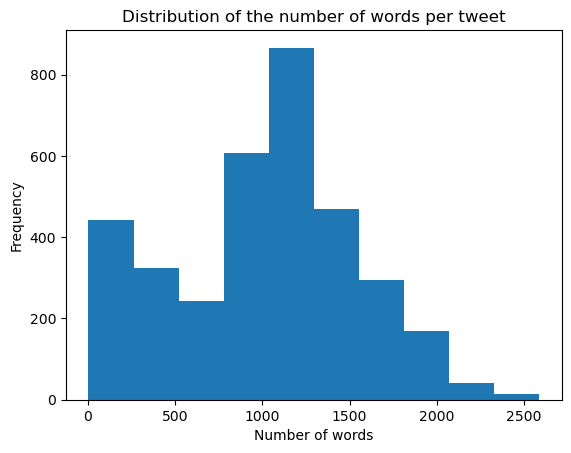

In [ ]:
df_cars["num_words"] = df_cars["Full Description"].apply(lambda x: len(x.split()))

# Create a histogram of the distribution of the number of words per tweet
plt.hist(df_cars['num_words'])
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of the number of words per tweet')
plt.show()

In [ ]:
df_cars_to_summarize = df_cars[df_cars["num_words"] > 750]
df_cars_not_to_summarize = df_cars[df_cars["num_words"] < 750]

In [ ]:
df_cars_not_to_summarize.to_csv("carsDescriptionPerfect.csv")

#### Bert Summarizer

In [ ]:
"""# loop through a column in the dataframe
for index, row in df_cars.iterrows():
    bert_model = Summarizer()
    row["Bert Summarization"] = ''.join(bert_model(row["Full Description"]))"""

'# loop through a column in the dataframe\nfor index, row in df_cars.iterrows():\n    bert_model = Summarizer()\n    row["Bert Summarization"] = \'\'.join(bert_model(row["Full Description"]))'

In [ ]:
"""bert_model = Summarizer()
#bert_summary = ''.join(bert_model(body, min_length=60))
bert_summary = ''.join(bert_model(df_cars["Full Description"][0]))
print(bert_summary)"""

'bert_model = Summarizer()\n#bert_summary = \'\'.join(bert_model(body, min_length=60))\nbert_summary = \'\'.join(bert_model(df_cars["Full Description"][0]))\nprint(bert_summary)'

#### GPT-2 summarizer

In [ ]:
"""# loop through a column in the dataframe
for index, row in df_cars.iterrows():
    GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
    row["GPT-2 Summarization"] = ''.join(GPT2_model(row["Full Description"]))"""

'# loop through a column in the dataframe\nfor index, row in df_cars.iterrows():\n    GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")\n    row["GPT-2 Summarization"] = \'\'.join(GPT2_model(row["Full Description"]))'

In [ ]:
# add a new column to store the summarization results
df_cars_to_summarize["GPT-2 Summarization"] = ""

In [ ]:
df_cars_to_summarize = df_cars_to_summarize.reset_index()

In [ ]:
# configure the logger
logging.basicConfig(level=logging.INFO)

# create a logger for tqdm
logger = logging.getLogger('tqdm')
logger.setLevel(logging.INFO)

In [ ]:
for index, row in tqdm(df_cars_to_summarize.iterrows(), total=len(df_cars_to_summarize), bar_format="{l_bar}{bar}{r_bar}", colour='green'):
    # create a logger for the current row
    #row_logger = logging.getLogger(f'row{index}')
    #row_logger.setLevel(logging.INFO)
    
    GPT2_model = TransformerSummarizer(transformer_type="GPT2", transformer_model_key="gpt2-medium")
    #print(GPT2_model(row["Full Description"]))
    row["GPT-2 Summarization"] = ''.join(GPT2_model(row["Full Description"]))
    df_cars_to_summarize.loc[index] = row
    
    # log the progress of the current row
    #row_logger.info(f'Processed row {index}')

  0%|          | 0/2482 [00:00<?, ?it/s]

100%|██████████| 2482/2482 [4:04:51<00:00,  5.92s/it]


In [ ]:
df_cars_to_summarize.head()

,index,car type,car name,year,url,Pros,Cons,Full Description,rating,current price Min,current price Max,base msrp,engine,drivetrain,dimensions,num_words,Full Name,GPT-2 Summarization
0,1,lexus,lexus is-350,2014,https://www.edmunds.com/lexus/is-350/2014/review/,"['Powerful and refined V6', 'superbly crafted ...","[""Handling isn't very sharp, even with the F S...","For 2014, the Lexus IS 350 is redesigned. High...",4.6 out of 5 stars,"$23,990","$27,990","$39,615 \n","V6 cylinder \n Horsepower: 306 hp @ 6,400 rpm ...",Type: rear wheel drive \n Transmission: 8-spee...,Length: 183.7 in. / Height: 56.3 in. \n Overal...,1732,lexus is-350 2014,"For 2014, the Lexus IS 350 is redesigned. We'r..."
1,4,acura,acura rdx,2017,https://www.edmunds.com/acura/rdx/2017/review/,['Strong acceleration and fuel economy from st...,['Technology interface can be distracting to u...,The Acura RDX essentially carries over unchang...,4.3 out of 5 stars,"$19,982","$29,990","$35,670 \n","V6 cylinder \n Horsepower: 279 hp @ 6,200 rpm ...",Type: front wheel drive \n Transmission: 6-spe...,Length: 184.4 in. / Height: 65.0 in. \n Overal...,1428,acura rdx 2017,The Acura RDX essentially carries over unchang...
2,5,chevrolet,chevrolet express,2014,https://www.edmunds.com/chevrolet/express/2014...,"['Wide-ranging powertrain lineup', 'variety of...","['Thirstier, less spacious and rougher riding ...","For 2014, the Chevrolet Express Passenger van ...",4.2 out of 5 stars,"$25,800","$27,000","$30,970 \n","V8 cylinder \n Horsepower: 310 hp @ 5,200 rpm ...",Type: rear wheel drive \n Transmission: 4-spee...,Length: 224.1 in. / Height: 82.1 in. \n Overal...,938,chevrolet express 2014,"For 2014, the Chevrolet Express Passenger van ..."
3,6,bmw,bmw x3-m,2021,https://www.edmunds.com/bmw/x3-m/2021/review/,"['Wickedly quick acceleration', 'Grip and hand...","['Excessively stiff ride, even in the softest ...","A pumped-up version of the standard X3, the 20...",4.7 out of 5 stars,"$54,659","$58,280","$69,900 \n","Inline 6 cylinder \n Horsepower: 473 hp @ 6,25...",Type: all wheel drive \n Transmission: 8-speed...,Length: 186.2 in. / Height: 65.6 in. \n Overal...,1164,bmw x3-m 2021,"A pumped-up version of the standard X3, the 20..."
4,7,ford,ford edge,2008,https://www.edmunds.com/ford/edge/2008/review/,"['Quiet and comfortable ride, agile handling, ...","['Questionable brakes, lackluster interior des...",The 2008 Ford Edge gets more luxury and conven...,4.6 out of 5 stars,"$7,682","$7,682","$25,735 \n","V6 cylinder \n Horsepower: 265 hp @ 6,250 rpm ...",Type: front wheel drive \n Transmission: 6-spe...,Length: 185.7 in. / Height: 67.0 in. \n Overal...,994,ford edge 2008,The 2008 Ford Edge gets more luxury and conven...


In [ ]:
df_cars_to_summarize.to_csv("carsDescriptionSummarized.csv")

In [ ]:
"""GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")
full = ''.join(GPT2_model(df_cars["Full Description"][0]))
print(full)"""

'GPT2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")\nfull = \'\'.join(GPT2_model(df_cars["Full Description"][0]))\nprint(full)'

#### XLNet Summarizer

In [ ]:
"""# loop through a column in the dataframe
for index, row in df_cars.iterrows():
    model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
    row["XLNet Summarization"] = ''.join(model(row["Full Description"]))"""

'# loop through a column in the dataframe\nfor index, row in df_cars.iterrows():\n    model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")\n    row["XLNet Summarization"] = \'\'.join(model(row["Full Description"]))'

In [ ]:
"""model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")
full = ''.join(model(df_cars["Full Description"][0]))
print(full)"""

'model = TransformerSummarizer(transformer_type="XLNet",transformer_model_key="xlnet-base-cased")\nfull = \'\'.join(model(df_cars["Full Description"][0]))\nprint(full)'

In [ ]:
"""df_cars_mod = df_cars[df_cars["num_words"] > 400]
df_cars_mod = df_cars_mod[df_cars_mod["num_words"] < 800]"""

'df_cars_mod = df_cars[df_cars["num_words"] > 400]\ndf_cars_mod = df_cars_mod[df_cars_mod["num_words"] < 800]'

In [ ]:
"""df_cars_mod.head()"""

'df_cars_mod.head()'

In [ ]:
"""df_cars_mod["num_words"] = df_cars_mod["Full Description"].apply(lambda x: len(x.split()))

# Create a histogram of the distribution of the number of words per tweet
plt.hist(df_cars_mod['num_words'])
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Distribution of the number of words per tweet')
plt.show()"""

'df_cars_mod["num_words"] = df_cars_mod["Full Description"].apply(lambda x: len(x.split()))\n\n# Create a histogram of the distribution of the number of words per tweet\nplt.hist(df_cars_mod[\'num_words\'])\nplt.xlabel(\'Number of words\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Distribution of the number of words per tweet\')\nplt.show()'

In [ ]:
"""df_cars_mod.info()"""

'df_cars_mod.info()'